# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import OrderedDict
from tqdm import tqdm

from torchsummary import summary

from albumentations.augmentations import transforms, Normalize
from albumentations import Flip, RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

# Hyperparameters

In [2]:
SIZE = 256
batch_size = 8
base_dir = '' # Local
num_workers = 1
lr = 0.0001
min_lr = 0.00001
epochs = 50
early_stopping = 5
# base_dir = '/content/' # Colab
root_path = os.path.join(base_dir, 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/')
semantic = False
device = torch.device('cuda:0')

classes = ['normal', 'benign', 'malignant']
labels = []
num_classes = 3 if semantic else 1

if semantic:
    labels = classes
else:
    labels = ['cancer']

# Preprocessing

In [3]:
def load_image(path, size=SIZE):
    image = cv2.imread(path)
    image = cv2.resize(image, (size, size))
    image = image[:, :, 0]
    image = image / 255.0
    image = np.expand_dims(image, 0)
    image = image.astype(np.double)
    return image

def load_mask(paths, size=SIZE):
    mask = np.zeros((size, size), dtype=int)

    for path in paths:
        for i in range(3):
            if classes[i] in path:
                cur_mask = cv2.imread(path)
                cur_mask = np.mean(cur_mask, axis=-1)
                cur_mask = cv2.resize(cur_mask, (size, size))
                mask[cur_mask != 0] = i if semantic else 1

    if semantic:
        mask = np.eye(num_classes)[mask]
        mask = mask.astype(np.double)
        mask = np.transpose(mask, (2, 0, 1))
    else:
        mask = np.expand_dims(mask, 0)
    return mask

def load_tensor(image_path, mask_path):
    image, mask = load_image(image_path), load_mask(mask_path)
    image = torch.tensor(image).to(device=device, dtype=torch.float)
    mask = torch.tensor(mask).to(device, dtype=torch.float)
    return image, mask

In [4]:
def show_image(img, msk, threshold=False):
    fig, axs = plt.subplots(1, 1 + len(labels), figsize=(8, 3))
    img = np.squeeze(img)

    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("image")

    for i in range(len(labels)):
        if semantic and threshold:
            # Create a binary mask based on the channel with the highest value
            binary_mask = np.argmax(msk, axis=0) == i
            axs[i + 1].imshow(binary_mask, vmin=0, vmax=1, cmap='gray')
        else:
            axs[i + 1].imshow(msk[i], vmin=0, vmax=1, cmap='gray')
        axs[i + 1].set_title(f"{labels[i]}")

    plt.show()

def show_mask(img, msk, cmap='gray', alpha=0.6): # only for binary segmentation
    img = np.squeeze(img)
    msk = np.squeeze(msk)

    msk = (msk >= 0.5)

    plt.imshow(img, cmap='gray')
    plt.imshow(msk, cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.show()

breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (1).png
(1, 256, 256)


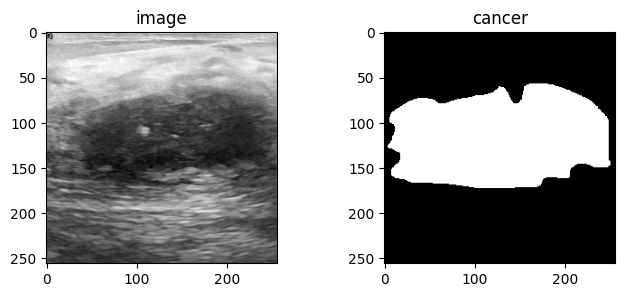

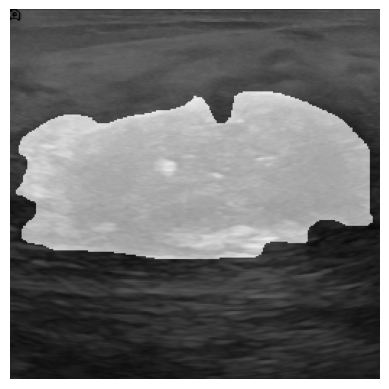

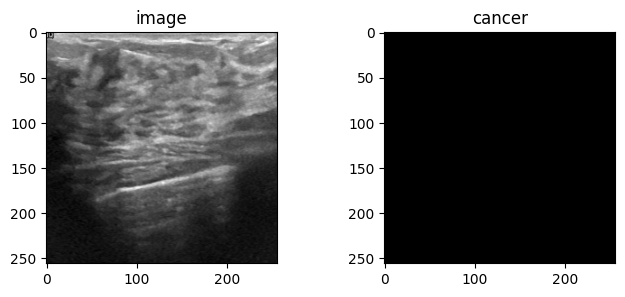

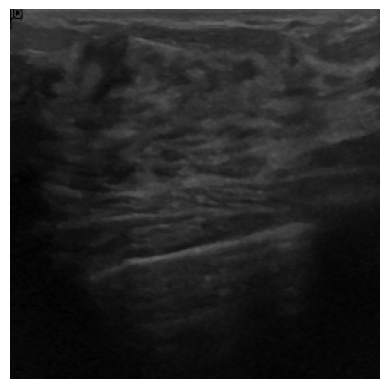

In [5]:
image_path = os.path.join(root_path, 'malignant/malignant (1).png')
mask_path = [os.path.join(root_path, 'malignant/malignant (1)_mask.png')]

print(image_path)

img, msk = load_image(image_path), load_mask(mask_path)
print(msk.shape)
show_image(img, msk)
show_mask(img, msk)

image_path = root_path + '/normal/normal (1).png'
mask_path = [root_path + '/normal/normal (1)_mask.png']

img, msk = load_image(image_path), load_mask(mask_path)
show_image(img, msk)
show_mask(img, msk)

In [6]:
print(root_path)

breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/


In [7]:
all_images = glob.glob(os.path.join(root_path, "**/*).png"), recursive=True)

image_paths = []
mask_paths = []

for path in all_images:
    if 'normal' in path:
        continue

    image_paths.append(path)
    cur_mask_path = []
    mask_path_1 = path.replace('.png', '_mask.png')
    mask_path_2 = path.replace('.png', '_mask_1.png')
    cur_mask_path.append(mask_path_1)
    if os.path.exists(mask_path_2):
        cur_mask_path.append(mask_path_2)
    mask_paths.append(cur_mask_path)

image_paths = np.array(image_paths)
mask_paths = np.array(mask_paths, dtype=object)

print(len(image_paths), len(mask_paths))

647 647


In [8]:
# # Truncation
# trunc = 25

# image_paths = image_paths[0:trunc]
# mask_paths = mask_paths[0:trunc]

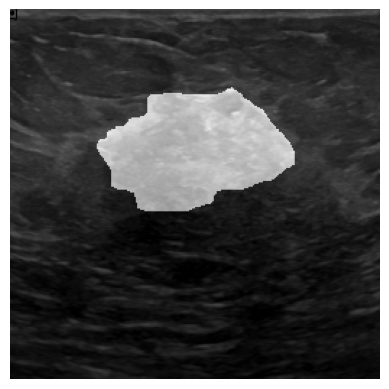

In [9]:
random_index = random.randint(0, len(image_paths) - 1)

random_image_path = image_paths[random_index]
random_mask_path = mask_paths[random_index]

random_img, random_msk = load_image(random_image_path), load_mask(random_mask_path)
show_mask(random_img, random_msk)

In [10]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths,  test_size=0.4, random_state=42)  # Split into 60% training, 40% remaining
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)  # Split remaining 40% into 50% testing, 50% validation

In [11]:
from torch.utils.data import Dataset
from torchvision import transforms

class BUSIDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image, mask = load_image(img_path), load_mask(mask_path)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(image).to(device=device, dtype=torch.float)
        mask = torch.tensor(mask).to(device, dtype=torch.float)
        return image, mask

In [12]:
train_transform = Compose([
    Normalize(mean = (0.5), std = (0.5)),
])

val_transform = Compose([
    Normalize(mean = (0.5), std = (0.5)),
])

# Create instances of the dataset for training, validation, and testing
train_dataset = BUSIDataset(image_paths=X_train, mask_paths=y_train, transform=train_transform)
val_dataset = BUSIDataset(image_paths=X_val, mask_paths=y_val, transform=val_transform)
test_dataset = BUSIDataset(image_paths=X_test, mask_paths=y_test, transform=None)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False)

In [13]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_layers = 4, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, n_filters)
        self.downs = nn.ModuleList([Down(n_filters * 2**i, n_filters * 2**(i+1)) for i in range(n_layers)])
        self.ups = nn.ModuleList([Up(n_filters * 2**(n_layers-i), n_filters * 2**(n_layers-i-1), bilinear) for i in range(n_layers)])
        self.outc = OutConv(n_filters, n_classes)

    def forward(self, x):
        x_skip_connections = []
        x = self.inc(x)
        x_skip_connections.append(x)
        
        for down in self.downs:
            x = down(x)
            x_skip_connections.append(x)
        
        for i, up in enumerate(self.ups):
            x = up(x, x_skip_connections[-(i+2)])
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        for down in self.downs:
            down = torch.utils.checkpoint(down)
        for up in self.ups:
            up = torch.utils.checkpoint(up)
        self.outc = torch.utils.checkpoint(self.outc)

In [14]:
# metrics

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice
    
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()
    iou = (intersection + smooth) / (union + smooth)
    dice = (2* iou) / (iou+1)
    return iou, dice


def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

In [15]:
# comparison

def compare_prediction(img, mask, pred):
    img = img.cpu().numpy()
    mask = mask.cpu().numpy()
    pred = pred.detach().cpu().numpy()

    img = np.squeeze(img)
    mask = np.squeeze(mask, axis=0)
    pred = np.squeeze(pred, axis=0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Image")

    if semantic:
        mask = mask[1:, :, :]
        gt_label = mask.sum(axis=(1, 2)).argmax()  # 1-based indexing
        axs[1].imshow(mask[gt_label, :, :], cmap='gray', vmin=0, vmax=1)
        axs[1].set_title(f"Ground Truth: {classes[gt_label + 1]}")

        pred = pred[1:, :, :, ]
        pred_label = pred.sum(axis=(1, 2)).argmax()  # 1-based indexing
        axs[2].imshow(pred[pred_label, :, :], cmap='gray', vmin=0, vmax=1)
        axs[2].set_title(f"Prediction: {classes[pred_label + 1]}")

    else:
        pred = np.where(pred >= 0.5, 1, 0)

        axs[1].imshow(mask[0], cmap='gray', vmin=0, vmax=1)
        axs[1].set_title(f"Ground Truth")

        axs[2].imshow(pred[0], cmap='gray', vmin=0, vmax=1)
        axs[2].set_title(f"Prediction")


def show_prediction(img, pred, threshold = False):
    img = img.cpu().numpy()
    pred = pred.detach().cpu().numpy()

    img = np.squeeze(img)
    pred = np.squeeze(pred, axis=0)


    if semantic and threshold:
        argmax_result = np.argmax(pred, axis=0)
        pred = np.eye(num_classes)[argmax_result]
        pred = np.transpose(pred, axes=(2, 0, 1))

    fig, axs = plt.subplots(1, 1 + len(labels), figsize=(12, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Image")

    for i in range(len(labels)):
        axs[i+1].imshow(pred[i], cmap='gray')
        axs[i+1].set_title(f"Label: {labels[i]}")

# Training

In [16]:
model = UNet(n_channels=1, n_classes=len(labels))
model = model.to(device=device)

# Define loss function and optimizer
criterion = BCEDiceLoss().cuda()  # Binary Cross-Entropy loss

optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer with learning rate 0.001
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=min_lr)

In [17]:
# Print model summary
print(summary(model, input_size=(1, SIZE, SIZE)))

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  576
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
├─ModuleList: 1-2                        --
|    └─Down: 2-2                         --
|    |    └─Sequential: 3-7              221,696
|    └─Down: 2-3                         --
|    |    └─Sequential: 3-8              885,760
|    └─Down: 2-4                         --
|    |    └─Sequential: 3-9              3,540,992
|    └─Down: 2-5                         --
|    |    └─Sequential: 3-10             14,159,872
├─ModuleList: 1-3                        --
|    └─Up: 2-6                           --
|    |    └─ConvTranspose2d: 3-11        2,097,664
|    |    └─DoubleConv: 3-12    

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:

# Training loop

def train(train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                   'dice': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input, target in train_loader:
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)
        iou,dice = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))
        avg_meters['dice'].update(dice, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
            ('dice', avg_meters['dice'].avg)
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

def validate(val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                   'dice': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target in val_loader:
            input = input.cuda()
            target = target.cuda()

            # compute output
            
            output = model(input)
            loss = criterion(output, target)
            iou,dice = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

In [20]:
log = OrderedDict([
    ('train_loss', []),
    ('train_iou', []),
    ('train_dice', []),
    ('val_loss', []),
    ('val_iou', []),
    ('val_dice', []),
])

best_iou = 0
trigger = 0

model_name = 'Vanilla_UNet'

for epoch in range(epochs):
    print('Epoch [%d/%d]' % (epoch, epochs))

    # train for one epoch
    train_log = train(train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(val_loader, model, criterion)
    scheduler.step()

    print(f"loss {train_log['loss']:.4f} - iou {train_log['iou']:.4f} - dice {train_log['dice']:.4f} - val_loss {val_log['loss']:.4f} - val_iou {val_log['iou']:.4f} - val_dice {val_log['dice']:.4f}") 

    # log['epoch'].append(epoch)
    log['train_loss'].append(train_log['loss'])
    log['train_iou'].append(train_log['iou'])
    log['train_dice'].append(train_log['dice'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])
    log['val_dice'].append(val_log['dice'])

    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                                model_name, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                    model_name)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

    # early stopping
    if early_stopping >= 0 and trigger >= early_stopping:
        print("=> early stopping")
        break

    torch.cuda.empty_cache()

Epoch [0/50]


  0%|          | 0/49 [00:00<?, ?it/s]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


  2%|▏         | 1/49 [00:00<00:39,  1.22it/s, loss=1.23, iou=0.0342, dice=0.0661]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


  4%|▍         | 2/49 [00:01<00:31,  1.51it/s, loss=1.19, iou=0.0997, dice=0.175] 

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


  6%|▌         | 3/49 [00:01<00:28,  1.64it/s, loss=1.17, iou=0.121, dice=0.211] 

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


  8%|▊         | 4/49 [00:02<00:26,  1.72it/s, loss=1.17, iou=0.135, dice=0.233]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 10%|█         | 5/49 [00:02<00:24,  1.79it/s, loss=1.16, iou=0.148, dice=0.254]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 12%|█▏        | 6/49 [00:03<00:24,  1.74it/s, loss=1.15, iou=0.162, dice=0.274]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 14%|█▍        | 7/49 [00:04<00:24,  1.74it/s, loss=1.15, iou=0.158, dice=0.268]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 16%|█▋        | 8/49 [00:04<00:23,  1.75it/s, loss=1.14, iou=0.171, dice=0.287]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 18%|█▊        | 9/49 [00:05<00:23,  1.74it/s, loss=1.14, iou=0.175, dice=0.293]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 20%|██        | 10/49 [00:05<00:22,  1.74it/s, loss=1.13, iou=0.186, dice=0.308]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 22%|██▏       | 11/49 [00:06<00:21,  1.78it/s, loss=1.13, iou=0.192, dice=0.316]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 24%|██▍       | 12/49 [00:06<00:20,  1.79it/s, loss=1.13, iou=0.197, dice=0.323]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 27%|██▋       | 13/49 [00:07<00:20,  1.76it/s, loss=1.12, iou=0.195, dice=0.321]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 29%|██▊       | 14/49 [00:08<00:19,  1.80it/s, loss=1.12, iou=0.204, dice=0.332]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 31%|███       | 15/49 [00:08<00:19,  1.77it/s, loss=1.11, iou=0.206, dice=0.336]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 33%|███▎      | 16/49 [00:09<00:18,  1.79it/s, loss=1.11, iou=0.209, dice=0.34] 

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


 35%|███▍      | 17/49 [00:09<00:17,  1.80it/s, loss=1.11, iou=0.203, dice=0.332]

(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256) (1, 256, 256)


KeyboardInterrupt: 

 55%|█████▌    | 27/49 [34:36<28:11, 76.91s/it, loss=0.227, iou=0.874, dice=0.932]


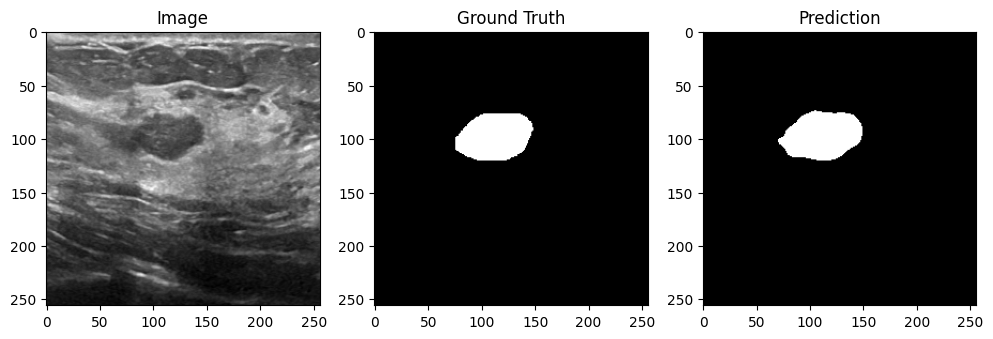

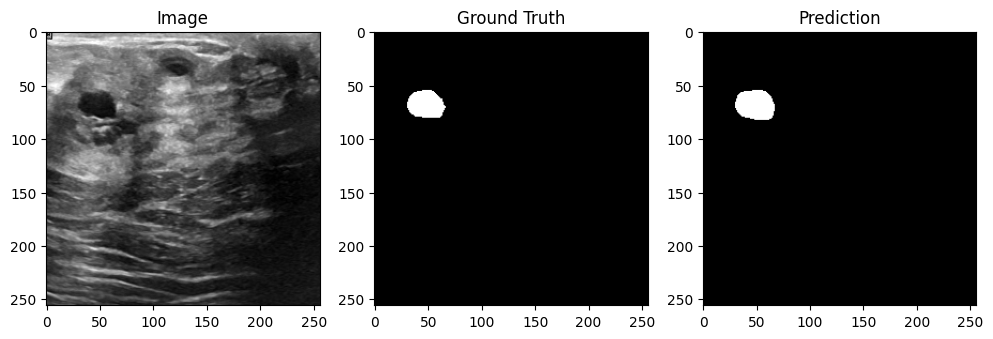

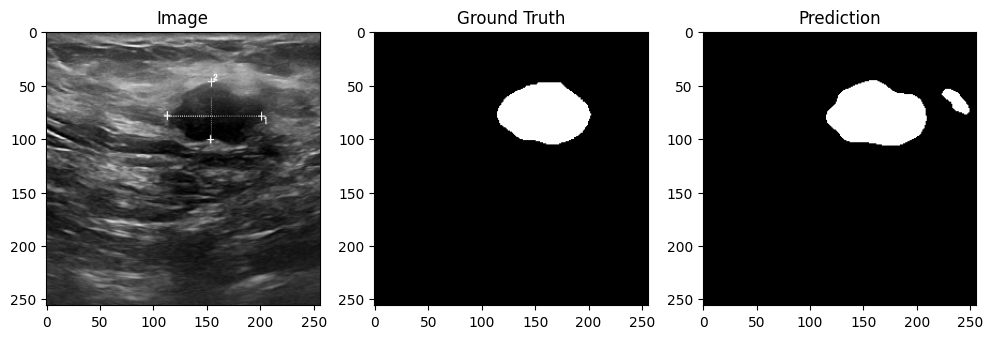

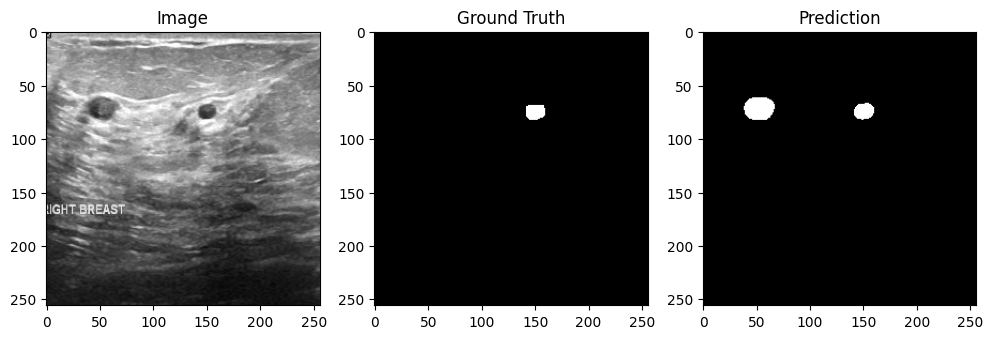

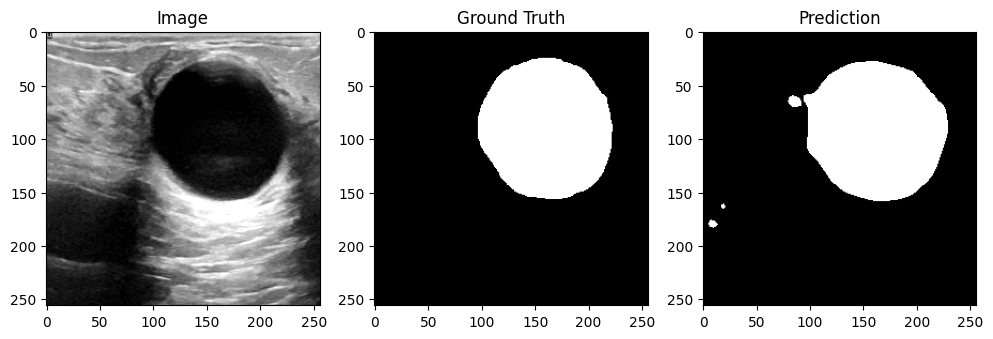

In [ ]:
count = 5

for _ in range(count):
    idx = random.randint(0, len(X_test) - 1)

    image, mask = load_tensor(X_test[idx], y_test[idx])
    mask = mask.unsqueeze(0)
    image = image.unsqueeze(0)
    vanilla_prediction = model(image)
    compare_prediction(image, mask, vanilla_prediction)
    # compare_prediction(image, mask, vanilla_prediction[0])

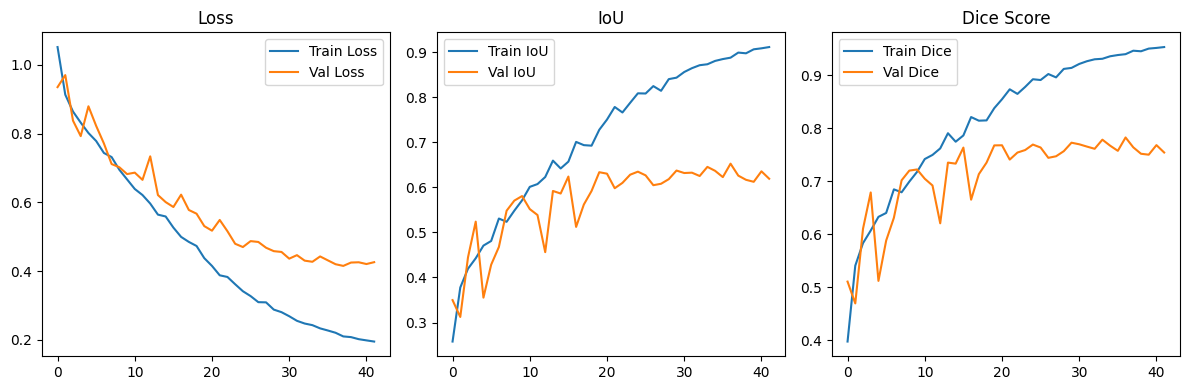

In [ ]:
log_data = pd.read_csv('models/%s/log.csv' % model_name)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(log_data['train_loss'], label='Train Loss')
plt.plot(log_data['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

# Plot training and validation IoU
plt.subplot(1, 3, 2)
plt.plot(log_data['train_iou'], label='Train IoU')
plt.plot(log_data['val_iou'], label='Val IoU')
plt.title('IoU')
plt.legend()

# Plot training and validation Dice score
plt.subplot(1, 3, 3)
plt.plot(log_data['train_dice'], label='Train Dice')
plt.plot(log_data['val_dice'], label='Val Dice')
plt.title('Dice Score')
plt.legend()

plt.tight_layout()
plt.show()